<a href="https://colab.research.google.com/github/PashaIanko/RestrictedBolzmannMachine/blob/EMNIST/Omniglot_learning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Helper links:
- https://github.com/pytorch/vision/blob/main/torchvision/datasets/omniglot.py

## **Packages, Constants & Functions**

In [1]:
# Preprocessing
SUBSET_SIZE_ = 5000
CROP_SIZE_ = 45
MEAN_ = 0.5
STD_ = 0.5
IMG_SIZE_ = CROP_SIZE_

# Train
EPOCHS_ = 50
BATCH_SIZE_ = 80
LABEL_FROM_ = 0
LABEL_TO_ = 28
LABEL_MIN_ = 0
LABEL_MAX_ = 963

# Receprive fields visualization
VISUALIZATION_THRESH_ = .08

# Alphabets
# key - alphabet, value - start and finish labels
ALPHABETS_DICT_ = {
    'First': [0, 25]  # Label limits
}

# Model
VISIBLE_UNITS_ = IMG_SIZE_ * IMG_SIZE_
HIDDEN_UNITS_ = [500, 500, 1200]
N_HIDDEN_LAYERS_ = len(HIDDEN_UNITS_)
K_ = 1
LEARNING_RATE_ = 0.07
LR_DECAY_ = False
INIT_MOMENTUM_ = 0.5
FIN_MOMENTUM_ = 0.9
W_DECAY_ = 0.00002
XAVIER_INIT_ = False
INCREASE_TO_CD_K_ = False
USE_GPU_ = True

In [2]:
%%capture

url_dbn = 'https://raw.githubusercontent.com/PashaIanko/RestrictedBolzmannMachine/main/DBN.py'
url_rbm = 'https://raw.githubusercontent.com/PashaIanko/RestrictedBolzmannMachine/main/RBM.py'

utils = {
    'DBN.py': url_dbn,
    'RBM.py': url_rbm
}

for file, url in utils.items():
    !wget -O {file} {url} {file}

In [3]:
import torch
import torchvision as tv
from torchvision import datasets

# Models
from DBN import DBN

# Plotting
import matplotlib.pyplot as plt

# Download
from google.colab import drive
from os import path

# Utils
from scipy import cluster
import numpy as np
import random
import math

# Plotting
import seaborn as sns

In [4]:
def fix_seeds():
    torch.manual_seed(0)
    random.seed(0)
    np.random.seed(0)

In [5]:
def visualize_symbols(dataset, n_subplots, image_shape):
    n_rows_cols = int(math.sqrt(n_subplots))
    fig, axes = plt.subplots(
        n_rows_cols, 
        n_rows_cols, 
        sharex = True,
        sharey = True,
        figsize = (10, 10)
    )
    for i in range(n_subplots):
        row = i % n_rows_cols
        col = i // n_rows_cols
        img, _ = dataset[i] 
        axes[row, col].imshow(torch.flatten(img).reshape(image_shape), cmap='binary')

In [6]:
def find_image(ds, label):
    for item in ds:
        if item[1] == label:
            return item[0]

def visualize_labels(labels, image_shape, ds):
    n_subplots = len(labels)
    
    n_rows_cols = int(math.sqrt(n_subplots))
    fig, axes = plt.subplots(
        n_rows_cols, 
        n_rows_cols, 
        sharex = True,
        sharey = True,
        figsize = (10, 10)
    )

    for i in range(n_subplots):
        col = i % n_rows_cols
        row = i // n_rows_cols
        label = labels[i]
        
        image = find_image(ds, label)
        axes[row, col].imshow(torch.flatten(image).reshape(image_shape), cmap='binary')

def prepare_data(ds, label_from, label_to):
    labels = []
    images = []
    for item in ds:
        if label_from <= item[1] <= label_to:
            labels.append(item[1])
            images.append(item[0])
    return images, labels

In [7]:
def move_parameters_to_cpu(dbn_mnist):
    for layer in dbn_mnist.rbm_layers:
        layer.W = layer.W.cpu()
        layer.h_bias = layer.h_bias.cpu()
        layer.v_bias = layer.v_bias.cpu()

def apply_threshold(weights, threshold=0):
    return weights * (abs(weights) > threshold)
  
def plot_layer_receptive_fields(weights_matrices, num_subplots = 64, 
                                img_width=IMG_SIZE_, img_height=IMG_SIZE_, 
                                fig_size = (20, 20)):
    n_rows_cols = int(math.sqrt(num_subplots))
    fig, axes = plt.subplots(n_rows_cols, n_rows_cols, sharex=True, sharey=True, figsize=fig_size)
    for i in range(num_subplots):
        row = i % n_rows_cols
        col = i // n_rows_cols
        
        # Matrix of connection strength (W) of i-th unit of the layer.
        # Reshape from 'linear' to 'image' representation
        W_matrix = weights_matrices[i, :].reshape((img_height, img_width))
        axes[row, col].imshow(W_matrix, cmap = plt.cm.gray)

In [8]:
def project_hidden_layer(weights_matrices, layer_numb):
    
    # layer_numb starts from 2 (number of hidden layer)
    
    layers = weights_matrices[:layer_numb]
    cur_layer = layers[0]
    for i in range(1, len(layers)):
        cur_layer = layers[i] @ cur_layer
    return cur_layer

## **Data Download**

- For neural networks, we need to scale data before learning
- Need to obtain tensor shape
- Fix seeds for reproducibility

In [9]:
%%capture 

transformer = tv.transforms.Compose(
    [
        tv.transforms.CenterCrop(CROP_SIZE_),
        tv.transforms.ToTensor(),
        
        # Transform to {-1, 1} binary image
        tv.transforms.Normalize(mean=(MEAN_,), std=(STD_)),

        # Rotate
        # tv.transforms.RandomRotation(degrees = 90) 
    ]
)

train = tv.datasets.EMNIST(
    root = 'data/',
    train = True,
    download = True,
    transform = transformer,
    split = 'digits',
    # shuffle = False
)
test = tv.datasets.EMNIST(
    root = 'data/',
    train = False,
    download = True,
    transform = transformer,
    split = 'digits',
    # shuffle_files = False
)

In [10]:
train = torch.utils.data.Subset(train, np.arange(SUBSET_SIZE_))
test = torch.utils.data.Subset(test, np.arange(SUBSET_SIZE_))

Image shape = torch.Size([1, 45, 45]), label = 8


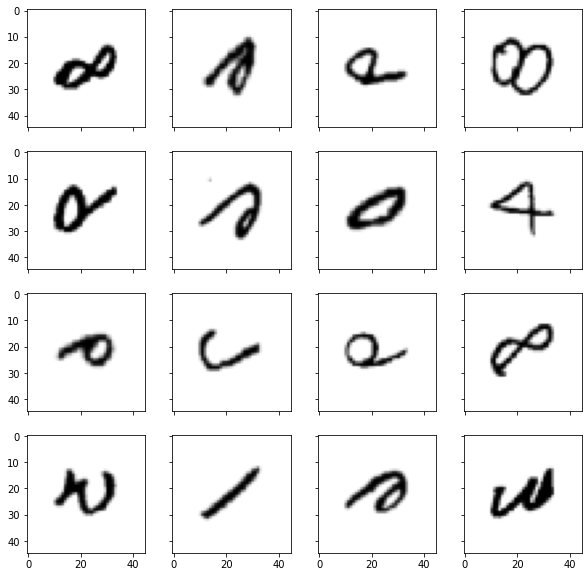

In [11]:
img, label = train[0]
print(f'Image shape = {img.shape}, label = {label}')
visualize_symbols(train, 16, image_shape = (CROP_SIZE_, CROP_SIZE_))

## **Data properties**

In [12]:
X_train = [item[0] for item in train]
Y_train = [item[1] for item in train]
X_test = [item[0] for item in test]
Y_test = [item[1] for item in test]


    Train size: 2000
    Train # Unique labels: 10
    Test size: 2000
    Test # Unique labels: 10
    


/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


Text(0.5, 1.0, 'Test class distribution')

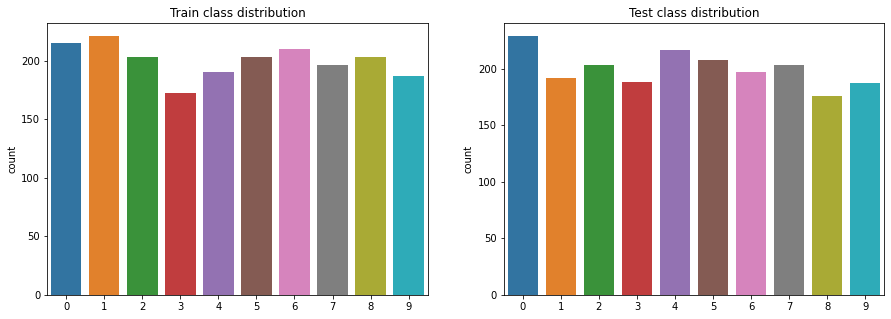

In [13]:
print(
    f"""
    Train size: {len(train)}
    Train # Unique labels: {len(np.unique(Y_train))}
    Test size: {len(test)}
    Test # Unique labels: {len(np.unique(Y_test))}
    """
)

fig, axes = plt.subplots(1, 2, figsize = (15, 5))
sns.countplot(Y_train, ax = axes[0])
axes[0].set_title('Train class distribution')
sns.countplot(Y_test, ax = axes[1])
axes[1].set_title('Test class distribution')

## **Visualize Data**

- 1st conclusion:  
    - 1 Dataset
    - 10 distinct symbols (for 'digits' split)
    - Approximately uniform class distribution
    - ~ 10% images per class
    - Digits are centered in the image and do not occupy the whole square (-> apply center crop)

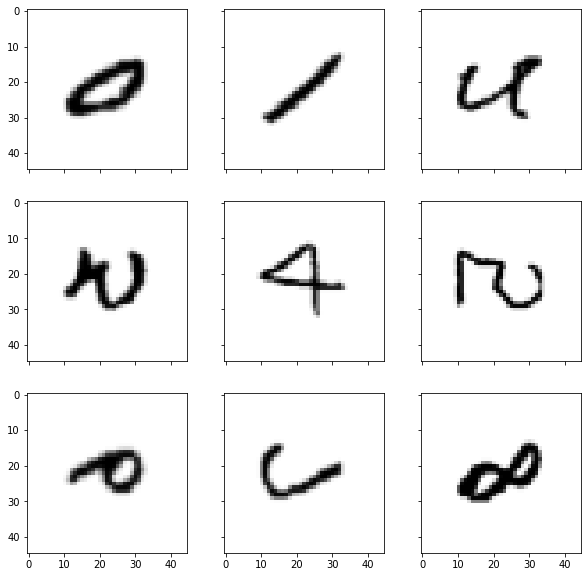

In [14]:
# Visualize first few symbols
visualize_labels(
    labels = [0, 1, 2,
              3, 4, 5,
              6, 7, 8
              ],
    image_shape = (IMG_SIZE_, IMG_SIZE_),
    ds = train
)

## **Prepare Data (Select alphabets & labels)**

In [15]:
# Slice and choose only subset of certain alphabet labels
images, labels = prepare_data(
    train, 
    label_from = 0,  
    label_to = 9
)
print(f'Size of the dataset = {len(labels)}')

Size of the dataset = 2000


In [16]:
# To Tensors
labels = torch.FloatTensor(labels)
buffer = torch.Tensor(len(images), IMG_SIZE_, IMG_SIZE_)
torch.cat(images, out=buffer)
images = buffer

In [17]:
print(type(labels), type(images))
print(type(labels[0]), type(images[0]))

<class 'torch.Tensor'> <class 'torch.Tensor'>
<class 'torch.Tensor'> <class 'torch.Tensor'>


## **Deep Belief Network model & fit**

- Deep Belief Network - a stack of Restricted Bolzmann Machines
    - RBM is a bipartite graph with input and hidden layer
    - Hidden layer captures dependencies and features
- Each layer learns more complex and abstract features
- Used as feature extraction method (generative model)
- No output neurons
- Two phases (negative & positive) during learning (reconstruction)




In [18]:
fix_seeds()

model = DBN(
    visible_units = VISIBLE_UNITS_,
    hidden_units = HIDDEN_UNITS_,
    k = K_,
    learning_rate = LEARNING_RATE_,
    learning_rate_decay = LR_DECAY_,
    initial_momentum = INIT_MOMENTUM_,
    final_momentum = FIN_MOMENTUM_,
    weight_decay = W_DECAY_,
    xavier_init = XAVIER_INIT_,
    increase_to_cd_k = INCREASE_TO_CD_K_,
    use_gpu = USE_GPU_
)

In [19]:
# %%capture

fix_seeds()

model.train_static(
    images,
    labels,
    EPOCHS_,
    BATCH_SIZE_
)

move_parameters_to_cpu(model)

--------------------
Training RBM layer 1
|Epoch |avg_rec_err |std_rec_err  |mean_grad |std_grad  |
|10    |75.9509   |0.1034   |599925.5625 |839.3013   |
|20    |75.9498   |0.1074   |570682.5625 |804.3754   |
|30    |75.9461   |0.1076   |542764.2500 |742.8774   |
|40    |75.9464   |0.1029   |516259.3750 |714.0489   |
|50    |75.9534   |0.1078   |491055.0938 |688.7954   |
--------------------
Training RBM layer 2
|Epoch |avg_rec_err |std_rec_err  |mean_grad |std_grad  |
|10    |0.0000   |0.0000   |4.5216 |0.0580   |
|20    |0.0000   |0.0000   |3.9269 |0.0074   |
|30    |0.0000   |0.0000   |3.7083 |0.0059   |
|40    |0.0000   |0.0000   |3.5181 |0.0054   |
|50    |0.0000   |0.0000   |3.3401 |0.0051   |
--------------------
Training RBM layer 3
|Epoch |avg_rec_err |std_rec_err  |mean_grad |std_grad  |
|10    |0.1327   |0.0860   |113.0288 |13.4307   |
|20    |0.1394   |0.1042   |79.2491 |12.6246   |
|30    |0.1245   |0.0922   |72.7871 |12.1830   |
|40    |0.1219   |0.0814   |67.7272 |11.87

## **Receptive fields visualization**

Lets understand the structure of network & layers
- Input layer size - (IMG_SIZE_ * IMG_SIZE_)
- 0-level of RBM network with N units -> has connection matrix W. 
Size of W = N_units * (IMG_SIZE_ * IMG_SIZE_)
- We can consider W matrix of 0-level as N "images" of size (IMG_SIZE_ * IMG_SIZE_)
- Hence, we can visualize connection strengths, starting from 0 hidden level

In [20]:
print(type(model.rbm_layers[0].W))
print(type(model.rbm_layers[0].W.numpy()))
print(model.rbm_layers[0].W.size())
print(model.rbm_layers[1].W.size())

<class 'torch.Tensor'>
<class 'numpy.ndarray'>
torch.Size([2025, 500])
torch.Size([500, 500])


### Preprocessing (filtering) learned weights matrices

In [21]:
# Converting and processing W matrices of hidden layers

learned_weights = [
    # We transpose for convenience (matrices[i, :] is more intuitive than matrices[:, i])
    model.rbm_layers[i].W.transpose(0, 1).numpy() for i in range(N_HIDDEN_LAYERS_)  
]

learned_weights_thresh = [apply_threshold(weights_matrix, VISUALIZATION_THRESH_) for weights_matrix in learned_weights]

### First hidden layer receptive fields

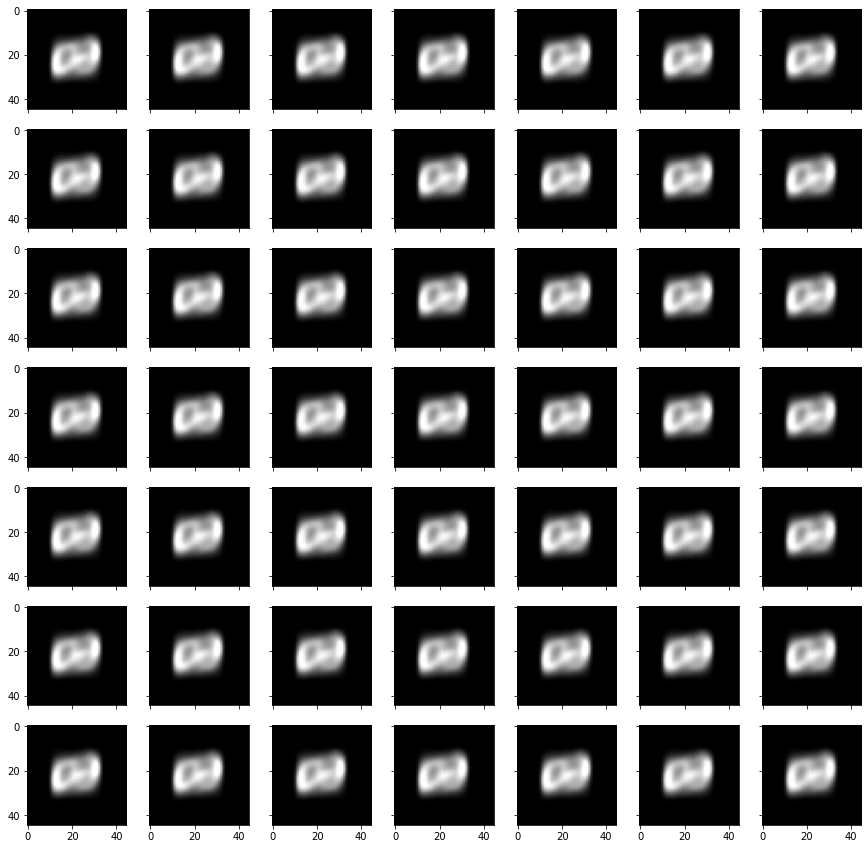

In [22]:
plot_layer_receptive_fields(
    # N_units * (img_size * img_size) - dimension of 1st hidden layer
    learned_weights_thresh[0],  
    num_subplots=49,
    img_height = IMG_SIZE_,
    img_width = IMG_SIZE_, 
    fig_size = (15, 15)
)

### Second hidden layer receptive field

- For example, in the architecture with units = [500, 500, 2000], the second hidden layer consists of 500 units, each associated with 500 units of the 1st hidden layer (500 x 500 matrix)
- We need to visualize (IMG_SIZE_ * IMG_SIZE_) images of 2nd hidden layer receptive fields
- The dimension of 1st hidden layer is n_units * (IMG_SIZE * IMG_SIZE).
- **Therefore**, we need to perform matrix multiplication, to turn (500 x 500) layer to (500 x (IMG_SIZE x IMG_SIZE)) layer

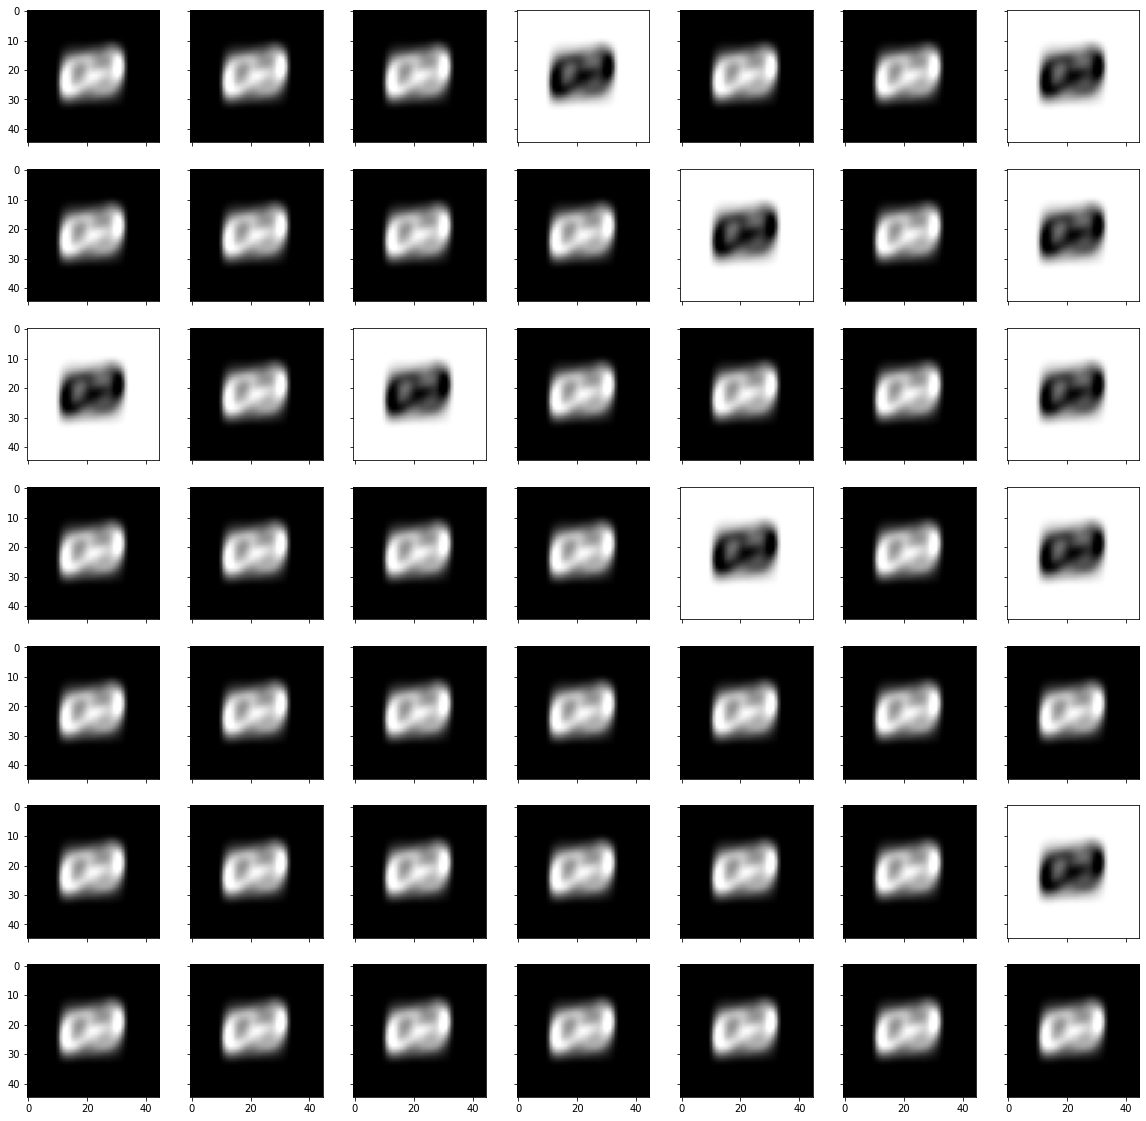

In [23]:
plot_layer_receptive_fields(
    project_hidden_layer(
        learned_weights_thresh,
        layer_numb = 2
    ), 
    num_subplots = 49
)

### Third hidden layer receptive fields

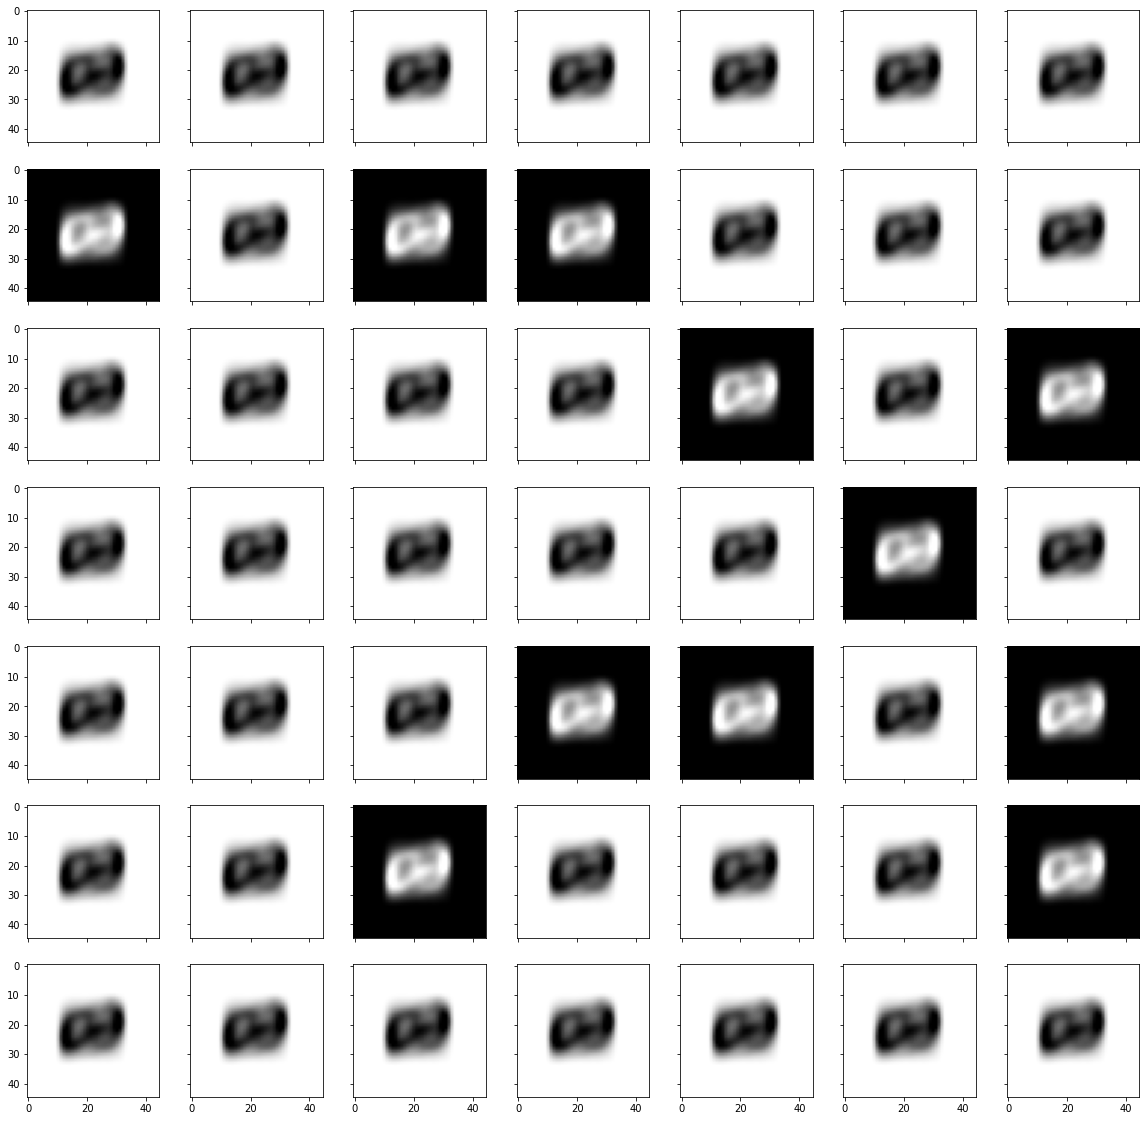

In [24]:
plot_layer_receptive_fields(
    project_hidden_layer(
        learned_weights_thresh,
        layer_numb = 3
    ), 
    num_subplots = 49
)

# Clustering internal representations

In [41]:
def get_layer_representation(input, model, layer_number):
    flattened_input = input.view((input.shape[0], -1)).type(torch.FloatTensor)
    hidden_repr, _ = model.rbm_layers[layer_number].to_hidden(flattened_input)
    return hidden_repr

In [42]:
hidden0 = get_layer_representation(
    input = images,
    model = model,
    layer_number = 0
)

In [27]:
hidden1 = get_layer_representation(
    input = hidden0,
    model = model,
    layer_number = 1
)

In [52]:
def get_mask(images, label):
    return labels.numpy() == label

def label_to_mean_hidden_repr(hidden_representation, images, labels):
    hidden_representation_np = hidden_representation.numpy()
    return {
        label: hidden_representation_np[get_mask(labels, label)].mean(axis=0)
        for label in np.unique(labels.numpy())
    }

def get_hidden_representation_matrix(label_to_mean_hidden_repr, labels):
    return np.concatenate(
        [np.expand_dims(
            label_to_mean_hidden_repr[label], axis = 0
        )
        for label in np.unique(labels.numpy())]
    )

In [54]:
label_to_mean0 = label_to_mean_hidden_repr(
    hidden0,
    images,
    labels
)

label_to_mean1 = label_to_mean_hidden_repr(
    hidden1,
    images,
    labels
)

In [55]:
mean_hidd_repr_mat0 = get_hidden_representation_matrix(
    label_to_mean0,
    labels
)

mean_hidd_repr_mat1 = get_hidden_representation_matrix(
    label_to_mean1,
    labels
)

In [56]:
def plot_dendrogram(mean_repr_matrix, title = ''):
    fig, ax = plt.subplots()
    linkage = cluster.hierarchy.linkage(mean_repr_matrix, method="complete")  # we run the clustering algorithm here
    dendrogram = cluster.hierarchy.dendrogram(linkage)
    ax.set_title(title)
    return dendrogram

/usr/local/lib/python3.7/dist-packages/scipy/cluster/hierarchy.py:2834: UserWarning: Attempting to set identical bottom == top == 0 results in singular transformations; automatically expanding.
  ax.set_ylim([0, dvw])


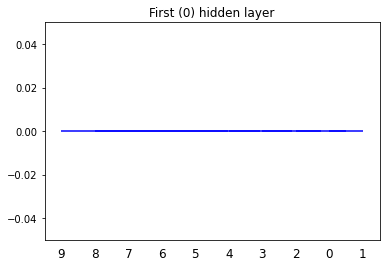

In [58]:
dendrogram0 = plot_dendrogram(
    mean_hidd_repr_mat0, 
    title = 'First (0) hidden layer'
)

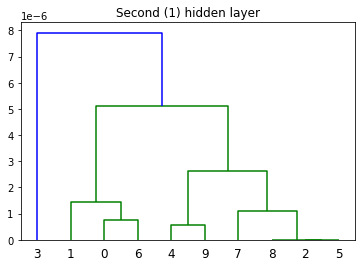

In [59]:
dendrogram1 = plot_dendrogram(
    mean_hidd_repr_mat1,
    title = 'Second (1) hidden layer'
)